In [1]:
print("""
Riker Wachtler
3 December 2023
NLP Midterm Project
https://github.com/RikerW/final-nlp
""")


Riker Wachtler
3 December 2023
NLP Midterm Project
https://github.com/RikerW/final-nlp



In [22]:
print("""
This is the completed version of my final project. I left short comments for each thing I'm doing - but in short,
it's doing some pre-processing stuff as EDA and then getting into it.

Then it does: 
TF-IDF into LDA
NER
WordClouds for a couple reviews for fun
Translation via TextBlob into Spanish
POS tagging
Word2Vec similarity checks
FreqDist from NLTK to find most common words
Sentiment Analysis using pre-trained BertTokenizer

The data is taken from a Rotten Tomatoes review compilation, as a text file.
""")


This is the completed version of my final project. I left short comments for each thing I'm doing - but in short,
it's doing some pre-processing stuff as EDA and then getting into it.

Then it does: 
TF-IDF into LDA
NER
WordClouds for a couple reviews for fun
Translation via TextBlob into Spanish
POS tagging
Word2Vec similarity checks
FreqDist from NLTK to find most common words
Sentiment Analysis using pre-trained BertTokenizer

The data is taken from a Rotten Tomatoes review compilation, as a text file.



In [2]:
# Just a lot of imports. A lot.

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
from textblob import TextBlob
import gensim

import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

import random

import warnings
warnings.filterwarnings("ignore")


import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

C:\Users\riker\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\riker\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\riker\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# basic loading + EDA - the txt file is a tab delimited df with sentences from Rotten Tomatoes reviews for sentiment analysis
df = pd.read_csv("data/datasetSentences.txt", index_col=0, delimiter = "\t")
df = df.dropna()

In [4]:
df.head()

,sentence
sentence_index,
1,The Rock is destined to be the 21st Century 's...
2,The gorgeously elaborate continuation of `` Th...
3,Effective but too-tepid biopic
4,If you sometimes like to go to the movies to h...
5,"Emerges as something rare , an issue movie tha..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11855 entries, 1 to 11855
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  11855 non-null  object
dtypes: object(1)
memory usage: 185.2+ KB


In [6]:
# There's an ungodly amount of reviews, so let's get 500 randomly selected to work with, so we're not dumping massive outputs
random.seed(10)
split = random.randint(0, 10000)
sentence_samples = df[split:split+500]
sentence_samples.reset_index(drop=True, inplace=True)
sentence_samples

,sentence
0,Although Barbershop boasts some of today 's ho...
1,A puzzle whose pieces do not fit .
2,"Some are fascinating and others are not , and ..."
3,Would that Greengrass had gone a tad less for ...
4,"The good is very , very good ... The rest runs..."
...,...
495,The movie 's plot is almost entirely witless a...
496,... may work as an addictive guilty pleasure b...
497,This Scarlet 's letter is A. . .
498,"as in aimless , arduous , and arbitrary ."


In [7]:
# Basic text cleaning function
def preprocess_text(text):
    words = word_tokenize(text)
    cleaned_words = word_tokenize(re.sub(r'[^a-zA-Z]', ' ', text))
    cleaned_words = [word.lower() for word in cleaned_words if word.isalnum() and word not in stop_words]
    return ' '.join(cleaned_words)

In [8]:
# Generate a processed version of our sentence samples
sentence_samples_processed = sentence_samples.copy()
for i in range(len(sentence_samples_processed)):
    sentence_samples_processed["sentence"][i] = preprocess_text(sentence_samples_processed["sentence"][i])
    
sentence_samples_processed

,sentence
0,although barbershop boasts today hottest hippe...
1,a puzzle whose pieces fit
2,some fascinating others end almost good movie
3,would greengrass gone tad less grit lot intell...
4,the good good the rest runs mildly unimpressiv...
...,...
495,the movie plot almost entirely witless inane c...
496,may work addictive guilty pleasure material ne...
497,this scarlet letter a
498,aimless arduous arbitrary


In [9]:
# TF-IDF vectorize this - and get the scores. used for LDA
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(sentence_samples_processed["sentence"][0:30])
tfidf_scores = tfidf_matrix.sum(axis=1)
tfidf_scores

matrix([[4.68484218],
        [2.        ],
        [2.63543752],
        [2.82656152],
        [2.70687955],
        [3.86874928],
        [3.46117423],
        [3.        ],
        [2.44741977],
        [2.44741977],
        [2.81847013],
        [3.604023  ],
        [2.23387547],
        [3.59983881],
        [3.46007783],
        [3.31176749],
        [3.31055591],
        [1.99672481],
        [1.72962232],
        [3.31174976],
        [3.15601017],
        [2.44741977],
        [3.60073272],
        [4.57528521],
        [2.44948974],
        [2.        ],
        [2.82656152],
        [2.82842712],
        [3.31498372],
        [2.69902625]])

In [10]:
# LDA get topics for the reviews. works OK considering they're single sentences :)

LDA = LatentDirichletAllocation(n_components = 20, random_state = 42)
LDA.fit(tfidf_matrix)

lda_components=LDA.components_
terms = tfidf.get_feature_names()
for index, component in enumerate(lda_components):
    top_terms_key=sorted(zip(terms, component), key = lambda t: t[1], reverse=True)[:5]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index+1)+": ",top_terms_list)

Topic 1:  ['wells', 'the', 'good', 'an', 'inexperienced']
Topic 2:  ['seems', 'even', 'movie', 'better', 'comedy']
Topic 3:  ['demeo', 'material', 'needs', 'talent', 'without']
Topic 4:  ['seems', 'even', 'movie', 'better', 'comedy']
Topic 5:  ['wrong', 'hands', 'peploe', 'simply', 'unbearable']
Topic 6:  ['seems', 'even', 'movie', 'better', 'comedy']
Topic 7:  ['almost', 'fascinating', 'others', 'some', 'end']
Topic 8:  ['constantly', 'implausibility', 'intelligence', 'maelstrom', 'observant']
Topic 9:  ['cloying', 'drama', 'eventually', 'gripping', 'initially']
Topic 10:  ['detached', 'hero', 'life', 'mood', 'oddly']
Topic 11:  ['definitely', 'guilty', 'category', 'enjoyable', 'fire']
Topic 12:  ['many', 'resurrection', 'one', 'entertaining', 'new']
Topic 13:  ['apparently', 'bothered', 'check', 'featuring', 'fewer']
Topic 14:  ['seems', 'even', 'movie', 'better', 'comedy']
Topic 15:  ['miss', 'near', 'soggy', 'timid', 'even']
Topic 16:  ['bore', 'casual', 'filmgoers', 'majority', 'p

In [11]:
colors = {'PERSON': 'linear-gradient(90deg, #aa9cfc, #fc9ce7)',
'DATE': 'linear-gradient(90deg, #34ebb4, #9c34eb)',
'ORG': 'linear-gradient(90deg, #eb3d34, #ebe834)',
'GPE': 'linear-gradient(90deg, #eb34d9, #bd0636)',
'TIME': 'linear-gradient(90deg, #9bbd06, #06bd89)',
'NORP': 'linear-gradient(90deg, #067dbd, #1206bd)',
'CARDINAL': 'linear-gradient(90deg, #06b4bd, #de0942)',
}
options = {'ents': ['PERSON', 'DATE', 'ORG', 'GPE', 'TIME', 'NORP', 'CARDINAL'], 'colors':colors}

In [20]:
# NER on the first 100 sentences with some funky colors I picked

for i in range(100):
    doc = nlp(sentence_samples_processed["sentence"][i])
    displacy.render(doc, style='ent', jupyter=True, options = options)

<Figure size 2000x1000 with 0 Axes>

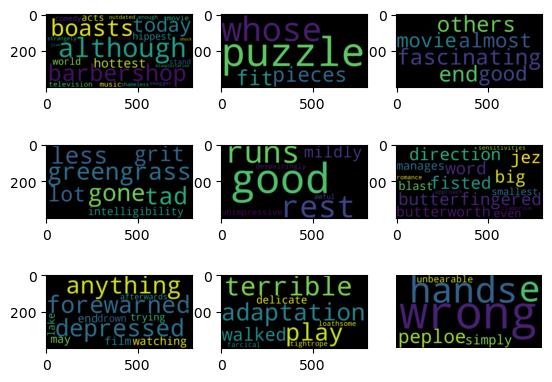

In [13]:
# WordClouds for the first 10 sentences
plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(3, 3)
plt.axis("off")
for i in range(3):
    for j in range(3):
        text = sentence_samples_processed["sentence"][3*i + j]
        wordcloud = WordCloud(width=800, height=400, background_color="black").generate(text)
        ax[i,j].imshow(wordcloud, interpolation="bilinear")
plt.show()

In [14]:
# Translate it to spanish because - why not?

for i in range(100):
    text = sentence_samples["sentence"][i]
    blob = TextBlob(text)
    translated_blob = blob.translate('en', 'es')
    print(translated_blob)

Aunque Barbershop cuenta con algunos de los actos más populares y modernos de hoy en el mundo de la televisión, la música y la comedia de pie, esta película extrañamente tiene la arrogancia desactualizada de una descarada incompleta de la comedia de sitios de los años 70 blaxploitation.
Un rompecabezas cuyas piezas no encajan.
Algunos son fascinantes y otros no, y al final, es casi una buena película.
¿Ese Greengrass había sido un poco menos para la arena y mucho más por la inteligibilidad?
Lo bueno es muy, muy bueno ... el resto funciona de un poco impresionante a desesperadamente horrible.
'Butterfingered' es la palabra para la dirección de Jez Butterworth, que logra explotar incluso las sensibilidades más pequeñas del romance con su enfoque clamoroso.
Tenga cuidado, si está deprimido por algo antes de ver esta película, es posible que termine tratando de ahogarse en un lago después.
Una terrible adaptación de una obra que solo caminó por la delicada cuerda floja entre lastre y repug

Debería haber valido la pena animar como un avance, pero está desprovisto de ingenio y humor.
Lo mejor de la película es su elenco agradable y divertido.
Estos tipos parecen geniales para tocar una cerveza, pero simplemente no son artistas divertidos.
Todo era tan superficial como el acento de bajo cebado forzado de Nueva Jersey Uma.
El director David Fincher y el escritor David Koepp Ca n't Surft It.
Finalmente, bajando de los estantes profundos de Miramax después de un par de intentos abortados, despertar en Reno presenta un argumento fuerte para dejar que los perros dormidos se encuentren.
Una película que se siente como el episodio piloto de una nueva serie de TV de acción dirigida a adolescentes.
Una de las decepciones más altamente presentadas que he tenido la desgracia de ver en bastante tiempo.
La animación y los fondos son exuberantes e inventivos, pero regresan a Neverland nunca se las arregla para llevarnos a ese lugar evasivo y encantador donde suspendemos nuestra increduli

In [15]:
# POS tagging for the first 10 sentences (more would get spammy)

for i in range(10):
    words = word_tokenize(sentence_samples_processed["sentence"][i])
    print(sentence_samples["sentence"][i])
    for j in sorted(list(set(nltk.pos_tag(words)))): print(j)
    print()

Although Barbershop boasts some of today 's hottest and hippest acts from the world of television , music and stand-up comedy , this movie strangely enough has the outdated swagger of a shameless ` 70s blaxploitation shuck-and-jive sitcom .
('acts', 'NNS')
('although', 'IN')
('barbershop', 'NN')
('blaxploitation', 'NN')
('boasts', 'NNS')
('comedy', 'NN')
('enough', 'RB')
('hippest', 'JJS')
('hottest', 'VBP')
('jive', 'JJ')
('movie', 'NN')
('music', 'NN')
('outdated', 'JJ')
('shameless', 'JJ')
('shuck', 'VBD')
('sitcom', 'NN')
('stand', 'VBP')
('strangely', 'RB')
('swagger', 'JJR')
('television', 'NN')
('today', 'NN')
('world', 'NN')

A puzzle whose pieces do not fit .
('a', 'DT')
('fit', 'VBP')
('pieces', 'NNS')
('puzzle', 'NN')
('whose', 'WP$')

Some are fascinating and others are not , and in the end , it is almost a good movie .
('almost', 'RB')
('end', 'VBP')
('fascinating', 'VBG')
('good', 'JJ')
('movie', 'NN')
('others', 'NNS')
('some', 'DT')

Would that Greengrass had gone a tad

In [16]:
# Example on how to use gensim word2vec for similarity
text = ". ".join(sentence_samples_processed["sentence"][:250])
text = [nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(text)]
model = gensim.models.Word2Vec(window=10, sg=1, hs=0, negative=10, alpha=0.03, min_alpha=0.0007, seed=4)
model.build_vocab(text, progress_per=200)
model.train(text, total_examples=model.corpus_count, epochs=10, report_delay=1)
print("Similarity of 'film', 'movie': %s" % model.wv.similarity("film", "movie"))

Similarity of 'film', 'movie': 0.9704475


Most common words (with #):
('the', 89)
('movie', 78)
('film', 67)
('a', 43)
('n', 37)
('one', 33)
('like', 30)
('it', 29)
('much', 24)
('even', 21)


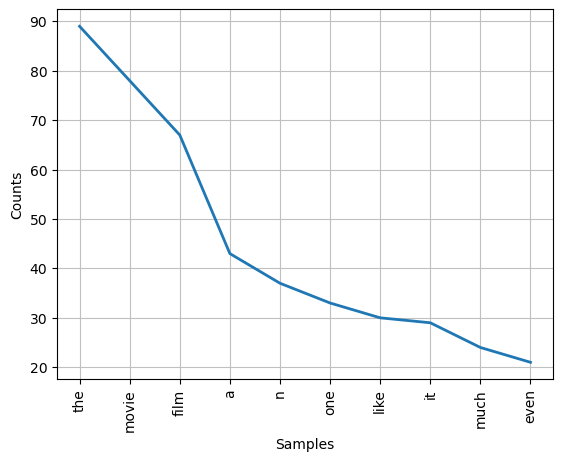

In [17]:
# Most frequent words in our dataset using FreqDist from nltk
text = word_tokenize(" ".join(sentence_samples_processed["sentence"]))

fdist = FreqDist(text)
print("Most common words (with #):")
for i in fdist.most_common(10): print(i)
fdist.plot(10)
plt.show()

In [18]:
# Sentiment analysis using a BertTokenizer (pre-trained), on the first 50 reviews
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name)

# Create a function to analyze sentiment
def analyze_sentiment(sentence):
    # Tokenize the input text
    inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors="tf")
    # Perform sentiment analysis
    output = model(inputs)
    predicted_class = tf.argmax(output.logits, axis=1).numpy()[0]
    return "Sentiment: " + ("Positive" if predicted_class == 1 else "Negative")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
for i in range(50):
    print("Review: " + sentence_samples["sentence"][i])
    print(analyze_sentiment(sentence_samples["sentence"][i]))

Review: Although Barbershop boasts some of today 's hottest and hippest acts from the world of television , music and stand-up comedy , this movie strangely enough has the outdated swagger of a shameless ` 70s blaxploitation shuck-and-jive sitcom .
Sentiment: Positive
Review: A puzzle whose pieces do not fit .
Sentiment: Positive
Review: Some are fascinating and others are not , and in the end , it is almost a good movie .
Sentiment: Positive
Review: Would that Greengrass had gone a tad less for grit and a lot more for intelligibility .
Sentiment: Positive
Review: The good is very , very good ... The rest runs from mildly unimpressive to despairingly awful .
Sentiment: Positive
Review: ` Butterfingered ' is the word for the big-fisted direction of Jez Butterworth , who manages to blast even the smallest sensitivities from the romance with his clamorous approach .
Sentiment: Positive
Review: Be forewarned , if you 're depressed about anything before watching this film , you may just end